## End Header

In [1]:
datadir = ['/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/validate_new_pcls_thrsh_rank_le20_k_med_gap_den_fast_retest_forloop_run1']
wkdir = fullfile(datadir,'pcls_all_no_loo_scoring_exclude_self_manu_cmpds_only')

mk_cd_dir(wkdir, true);
imatlab_export_fig('print-png')

col_meta_path = '/idi/cgtb/morzech/idmp/combine_screens_456/col_meta.txt'
%col_meta_path = '/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/loocv_pcls/col_meta_kabx.txt'
kabx_annot_path = '/idi/cgtb/abond/annotation/KABX_for_manuscript_20240413.xlsx'

figdir = 'by_pcl_plots_median_corr_rank_ppv_per_cmpd'

remove_broad_sar = true

pcls_moa_path = ['/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/pcls_spectral_clustering_thrsh_rank_le20_k_med_gap_den_fast_retest_forloop_run1/pcls_spectral_clust.gmt']
%c_path = '/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/validate_new_pcls_thrsh_rank_le20_k_med_gap_den/pcls_all_no_loo_scoring_exclude_self/ds_corr_n6555x79873.gctx'
%c_rank_path = '/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/validate_new_pcls_thrsh_rank_le20_k_med_gap_den/pcls_all_no_loo_scoring_exclude_self/ds_corr_rank_n6555x79873.gctx'

%pcl_stats_path = '/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/verify_new_pcls_thrsh_rank_le20_k_med_gap_den/figures_corr_summary.txt'


datadir =

    '/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/validate_new_pcls_thrsh_rank_le20_k_med_gap_den_fast_retest_forloop_run1'


wkdir =

    '/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/validate_new_pcls_thrsh_rank_le20_k_med_gap_den_fast_retest_forloop_run1/pcls_all_no_loo_scoring_exclude_self_manu_cmpds_only'


col_meta_path =

    '/idi/cgtb/morzech/idmp/combine_screens_456/col_meta.txt'


kabx_annot_path =

    '/idi/cgtb/abond/annotation/KABX_for_manuscript_20240413.xlsx'


figdir =

    'by_pcl_plots_median_corr_rank_ppv_per_cmpd'


remove_broad_sar =

  logical

   1


pcls_moa_path =

    '/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/pcls_spectral_clustering_thrsh_rank_le20_k_med_gap_den_fast_retest_forloop_run1/pcls_spectral_clust.gmt'



In [2]:
exist(col_meta_path) > 0
exist(kabx_annot_path) > 0

exist(pcls_moa_path) > 0
%exist(c_path) > 0
%exist(c_rank_path) > 0

%exist(pcl_stats_path) > 0

assert(exist(col_meta_path) > 0)
assert(exist(kabx_annot_path) > 0)

assert(exist(pcls_moa_path) > 0)


ans =

  logical

   1


ans =

  logical

   1


ans =

  logical

   1



In [3]:
ls

02b_screen6_annotate_results_and_make_gct.ipynb
03b_analyze_results_from_pcls_and_find_threshold_by_pcl_median_corr_ppv_per_cmpd_run_no_parallel_pert_id_moa_separable_only_parameterized.ipynb
ds_corr_n7233x10819.gctx
ds_corr_rank_n7233x10819.gctx
pcl_median_corr_n10819x1948.gctx
pcl_median_corr_rank_div_group_size_n10819x1948.gctx
pcl_median_corr_rank_n10819x1948.gctx
run_03b_analyze_results_from_pcls_and_find_threshold_by_pcl_median_corr_ppv_per_cmpd_run_no_parallel_pert_id_moa_separable_only.sh



## Load column metadata

In [4]:
col_meta = rtable(col_meta_path);
size(col_meta)

if any(strcmp('pcl_desc', col_meta.Properties.VariableNames))
    col_meta = removevars(col_meta, 'pcl_desc');
end

headt(col_meta)

Reading /idi/cgtb/morzech/idmp/combine_screens_456/col_meta.txt


ans =

       79873          33


ans =

  33x3 table

    idx               field                              value               
    ___    ___________________________    ___________________________________

     1     {'cid'                    }    {'tbda1:0013X 55UXB:0.781250uM'   }
     2     {'broad_id'               }    {'0013X 55UXB'                    }
     3     {'canonical_smiles'       }    {'-666'                           }
     4     {'cid_org'                }    {'tbda1:0013X 55UXB:0.781250uM'   }
     5     {'dose_series_id'         }    {'tbda_100.0'                     }
     6     {'n_replicates'           }    {[                              2]}
     7     {'pert_dose'              }    {[                         0.7812]}
     8     {'pert_dose_act'          }    {[                         0.7812]}
     9     {'pert_dose_unit'         }    {'uM'                             }
    10     {'pert_id

## Load KABX annotation

In [5]:
kabx_annot_path
kabx_annot = xls2table(kabx_annot_path,1,true);


kabx_annot_path =

    '/idi/cgtb/abond/annotation/KABX_for_manuscript_20240413.xlsx'

1 pert_id
2 pert_id_count
3 pert_id_alt
4 pert_id_pubchem_cid
5 pubchem_link
6 pert_iname
7 pert_class
8 pert_reference
9 target_process
10 target_pathway
11 target_description
12 target_description_long
13 target_description_multi_detailed
14 protein_target
15 gene_target
16 hypomorph_target
17 hypomorph_interest
18 ProdrugActivation_
19 notes
20 evidence_type
21 computational
22 biochemical
23 genetic
24 high_confidence
25 canonical_smiles
26 inchi_key
27 inchi_key_prefix
28 inchi_key_prefix_count


## Load Broad SAR Annotation

## Merge column metadata with KABX annotation

In [6]:
col_meta = outerjoin(col_meta,kabx_annot,'Keys','pert_id','RightVariables',{'target_description','protein_target'},...
    'Type','left','MergeKeys',true);

In [7]:
size(col_meta)
headt(col_meta)


ans =

       79873          35


ans =

  35x3 table

    idx               field                              value               
    ___    ___________________________    ___________________________________

     1     {'cid'                    }    {'tbda1:0013X 55UXB:0.781250uM'   }
     2     {'broad_id'               }    {'0013X 55UXB'                    }
     3     {'canonical_smiles'       }    {'-666'                           }
     4     {'cid_org'                }    {'tbda1:0013X 55UXB:0.781250uM'   }
     5     {'dose_series_id'         }    {'tbda_100.0'                     }
     6     {'n_replicates'           }    {[                              2]}
     7     {'pert_dose'              }    {[                         0.7812]}
     8     {'pert_dose_act'          }    {[                         0.7812]}
     9     {'pert_dose_unit'         }    {'uM'                             }
    10     {'pert_id'                }    {'0013X 55UXB'                    }
    11 

In [8]:
idx = ismember(col_meta.target_description,{'NaN','unknown','whole cell only'});
sum(idx)
col_meta.target_description(idx) = {''};


ans =

     0



## Merge column metadata with Broad SAR annotation

## Parse PCLs stats (skip)

### Remove Broad SAR PCLs (unpublished/series without known target)

## Parse gctx with the PCL score

In [9]:
%g = glob(fullfile(wkdir,'pcl_median_corr_rank_div_group_size_n*.gctx'))
g = glob(fullfile(wkdir,'pcl_median_corr_n*.gctx'))
s = parse_gctx(g{1});


g =

  1x1 cell array

    {'/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/validate_new_pcls_thrsh_rank_le20_k_med_gap_den_fast_retest_forloop_run1/pcls_all_no_loo_scoring_exclude_self_manu_cmpds_only/pcl_median_corr_n10819x1948.gctx'}

Reading /idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/validate_new_pcls_thrsh_rank_le20_k_med_gap_den_fast_retest_forloop_run1/pcls_all_no_loo_scoring_exclude_self_manu_cmpds_only/pcl_median_corr_n10819x1948.gctx [1948x10819]
Done [1.16 s].


In [10]:
s.chd


ans =

  8x1 cell array

    {'broad_id'            }
    {'frac_gr_le0_30'      }
    {'pert_dose'           }
    {'pert_id'             }
    {'pert_idose'          }
    {'rcorr'               }
    {'rcorr_rank'          }
    {'x_median_total_count'}



### Remove Broad SAR PCLs (unpublished/series without known target) from results

## Annotate gct object with column metadata

In [11]:
s = annotate_ds(s,table2struct(col_meta),'dim','column','keyfield','cid');

In [12]:
s.chd


ans =

  37x1 cell array

    {'broad_id'               }
    {'canonical_smiles'       }
    {'cid_org'                }
    {'dose_series_id'         }
    {'n_replicates'           }
    {'pert_dose'              }
    {'pert_dose_act'          }
    {'pert_dose_unit'         }
    {'pert_id'                }
    {'pert_idose'             }
    {'pert_idose_tickl'       }
    {'pert_itime'             }
    {'pert_time'              }
    {'pert_time_unit'         }
    {'pert_type'              }
    {'project_id'             }
    {'sample_id'              }
    {'trt_id'                 }
    {'trt_id_count'           }
    {'x_cid_original'         }
    {'x_cid_original_prev'    }
    {'x_csv_broad_id'         }
    {'x_csv_compound'         }
    {'x_csv_concentration'    }
    {'x_csv_n_replicates'     }
    {'x_csv_pert_dose'        }
    {'x_csv_x_pert_collection'}
    {'x_dose_series_id'       }
    {'x_median_total_count'   }
    {'x_pert_collection'      }
    {'x_repli

## Select all profiles regardless of rcorr

In [13]:
%cidx = cell2mat(s.cdesc(:,s.cdict('rcorr')))>=0.0;
%sum(cidx)
disp(sprintf('Total number of compounds: %d', numel(unique(s.cdesc(:,s.cdict('broad_id'))))))
%disp(sprintf('Total number of compounds with high rcorr: %d', numel(unique(s.cdesc(cidx,s.cdict('broad_id'))))))

Total number of compounds: 679


## Check which compounds have annotation

In [14]:
tabulate(s.cdesc(:,s.cdict('x_pert_collection')))

                 Value    Count   Percent
                  kabx     8363     77.30%
  pool_reproducibility       64      0.59%
        kabx_extension      136      1.26%
                  s4wk      162      1.50%
                  -666      290      2.68%
  broad_sar_literature      128      1.18%
                poscon      200      1.85%
                   dxr        8      0.07%
                fadD32       24      0.22%
       fadD32 coumarin       32      0.30%
                    bi       16      0.15%
                 Otava        2      0.02%
        inplate_poscon       10      0.09%
                  tbda     1384     12.79%


In [15]:
cidx = ismember(s.cdesc(:,s.cdict('x_pert_collection')),{'kabx','kabx_extension'});
sum(cidx)
sortrows(cell2table(tabulate(s.cdesc(cidx,s.cdict('target_description'))),...
    'VariableNames',{'target_description','count','percent'}),1)


ans =

        8499


ans =

  74x3 table

                          target_description                           count    percent
    _______________________________________________________________    _____    _______

    {'30S ribosome'                                               }     417      4.9065
    {'30S ribosome|InfB'                                          }      40     0.47064
    {'30S ribosome|tRNA synthesis'                                }      20     0.23532
    {'50S ribosome'                                               }     660      7.7656
    {'50S ribosome|FusA1'                                         }      40     0.47064
    {'ATP synthase'                                               }      38     0.44711
    {'AccD6'                                                      }      60     0.70597
    {'Alr'                                                        }     320      3.7651
    {'Alr|DdlA'                                                   }      20

In [16]:
cidx = ~cellfun(@isempty,s.cdesc(:,s.cdict('target_description')));
sum(cidx)
tabulate(s.cdesc(cidx,s.cdict('x_pert_collection')))
sortrows(cell2table(tabulate(s.cdesc(cidx,s.cdict('target_description'))),...
    'VariableNames',{'target_description','count','percent'}),1)


ans =

        9427

                 Value    Count   Percent
                  kabx     8363     88.71%
  pool_reproducibility       64      0.68%
        kabx_extension      136      1.44%
                  s4wk      154      1.63%
                  -666      290      3.08%
  broad_sar_literature      128      1.36%
                poscon      200      2.12%
                   dxr        8      0.08%
                fadD32       24      0.25%
       fadD32 coumarin       32      0.34%
                    bi       16      0.17%
                 Otava        2      0.02%
        inplate_poscon       10      0.11%

ans =

  81x3 table

                          target_description                           count    percent 
    _______________________________________________________________    _____    ________

    {'30S ribosome'                                               }     417       4.4235
    {'30S ribosome|InfB'                                          }      40      0.4243

In [17]:
cidx = ~cellfun(@isempty,s.cdesc(:,s.cdict('target_description'))) & ...
    ~ismember(s.cdesc(:,s.cdict('x_pert_collection')),{'kabx','kabx_extension'});
sum(cidx)
sortrows(cell2table(tabulate(s.cdesc(cidx,s.cdict('target_description'))),...
    'VariableNames',{'target_description','count','percent'}),1)


ans =

   928


ans =

  36x3 table

              target_description               count    percent
    _______________________________________    _____    _______

    {'50S ribosome'                       }     80       8.6207
    {'Alr|DdlA'                           }      8      0.86207
    {'CoaBC'                              }     16       1.7241
    {'CydAB'                              }     16       1.7241
    {'DHFR'                               }     68       7.3276
    {'DHFR|ThyAX'                         }     68       7.3276
    {'DHPS'                               }     16       1.7241
    {'DprE1-DprE2 complex'                }     24       2.5862
    {'Dxr'                                }      8      0.86207
    {'EmbABC'                             }      8      0.86207
    {'FadD32'                             }     56       6.0345
    {'GyrAB'                              }     80       8.6207
    {'GyrAB|DnaG'                         }     24       2.5862
 

## Select profiles from KABX

In [18]:
cidx = ~cellfun(@isempty,s.cdesc(:,s.cdict('target_description')));
sum(cidx)


ans =

        9427



In [19]:
sortrows(cell2table(tabulate(s.cdesc(cidx,s.cdict('target_description'))),...
    'VariableNames',{'target_description','count','percent'}),1)


ans =

  81x3 table

                          target_description                           count    percent 
    _______________________________________________________________    _____    ________

    {'30S ribosome'                                               }     417       4.4235
    {'30S ribosome|InfB'                                          }      40      0.42431
    {'30S ribosome|tRNA synthesis'                                }      20      0.21216
    {'50S ribosome'                                               }     740       7.8498
    {'50S ribosome|FusA1'                                         }      40      0.42431
    {'ATP synthase'                                               }      38       0.4031
    {'AccD6'                                                      }      60      0.63647
    {'Alr'                                                        }     320       3.3945
    {'Alr|DdlA'                                                   }      28      0.2970

In [20]:
ss = s


ss = 

  struct with fields:

        mat: [1948x10819 single]
        rid: {1948x1 cell}
        rhd: {5x1 cell}
      rdesc: {1948x5 cell}
        cid: {10819x1 cell}
        chd: {37x1 cell}
      cdesc: {10819x37 cell}
      rdict: [5x1 containers.Map]
      cdict: [37x1 containers.Map]
        src: '/idi/cgtb/abond/combine_screens_456/pcls_for_manuscript_final/validate_new_pcls_thrsh_rank_le20_k_med_gap_den_fast_retest_forloop_run1/pcls_all_no_loo_scoring_exclude_self_manu_cmpds_only/pcl_median_corr_n10819x1948.gctx'
    version: 'GCTX1.0'
     h5path: '/0/DATA/0/matrix'
     h5name: 'unnamed'



In [21]:
col_meta_ss = cell2table([ss.cid,ss.cdesc],'VariableNames',['cid';ss.chd]);
col_meta_ss.target_description = any2str(col_meta_ss.target_description);
headt(col_meta_ss)
unique(col_meta_ss.target_description)

row_meta_ss = cell2table([ss.rid,ss.rdesc],'VariableNames',['rid';ss.rhd]);
row_meta_ss.pcl_desc = any2str(row_meta_ss.pcl_desc);
headt(row_meta_ss)
unique(row_meta_ss.pcl_desc)


ans =

  38x3 table

    idx               field                                  value                   
    ___    ___________________________    ___________________________________________

     1     {'cid'                    }    {'kabx2:BRD-A05468928-003-01-4:0.097500uM'}
     2     {'broad_id'               }    {'BRD-A05468928-003-01-4'                 }
     3     {'canonical_smiles'       }    {'-666'                                   }
     4     {'cid_org'                }    {'kabx2:BRD-A05468928-003-01-4:0.097500uM'}
     5     {'dose_series_id'         }    {'kabx_dose_series'                       }
     6     {'n_replicates'           }    {[                                      2]}
     7     {'pert_dose'              }    {[                                 0.0975]}
     8     {'pert_dose_act'          }    {[                                 0.0975]}
     9     {'pert_dose_unit'         }    {'uM'                                     }
    10     {'pert_id'          

In [22]:
[a,b] = ind2sub(size(ss.mat),1:numel(ss.mat));

In [23]:
ss_tbl = [col_meta_ss(b,:),row_meta_ss(a,:)];
size(ss_tbl)
ss_tbl.pcl_score = ss.mat(:);


ans =

    21075412          44



## Rank PCLs for every sample

In [24]:
ss_rank = ss;
ss_rank.mat = rankorder(ss.mat,'descend');

In [25]:
isequal(ss.rid,ss_rank.rid)
isequal(ss.cid,ss_rank.cid)


ans =

  logical

   1


ans =

  logical

   1



In [26]:
ss_tbl.rank_pcl = ss_rank.mat(:);

In [27]:
myNewCellArray = cellfun(@(x) strsplit(x,':'), ss.rid, 'UniformOutput', false);
pcl_desc_for_matching = cellfun(@(x) x{1}, myNewCellArray, 'UniformOutput', false);

In [28]:
ss = ds_add_meta(ss, 'row', 'pcl_desc_for_matching', pcl_desc_for_matching);

In [29]:
target_desc = unique(ss.cdesc(:, ss.cdict('target_description')));
length(target_desc)
target_desc


ans =

    82


target_desc =

  82x1 cell array

    {0x0 char                                                     }
    {'30S ribosome'                                               }
    {'30S ribosome|InfB'                                          }
    {'30S ribosome|tRNA synthesis'                                }
    {'50S ribosome'                                               }
    {'50S ribosome|FusA1'                                         }
    {'ATP synthase'                                               }
    {'AccD6'                                                      }
    {'Alr'                                                        }
    {'Alr|DdlA'                                                   }
    {'CoaBC'                                                      }
    {'CydAB'                                                      }
    {'Cyp121'                                                     }
    {'CysH'                                                      

In [30]:
pcl_desc = unique(ss.rdesc(:,ss.rdict('pcl_desc')));
length(pcl_desc)
pcl_desc


ans =

    71


pcl_desc =

  71x1 cell array

    {'30S ribosome'                            }
    {'50S ribosome'                            }
    {'ATP synthase'                            }
    {'AccD6'                                   }
    {'Alr'                                     }
    {'CoaA and PyrG'                           }
    {'CoaBC'                                   }
    {'CydAB'                                   }
    {'Cyp121'                                  }
    {'CysH'                                    }
    {'DHFR'                                    }
    {'DHPS'                                    }
    {'DdlA'                                    }
    {'DnaG'                                    }
    {'DprE1-DprE2 complex'                     }
    {'Dxr'                                     }
    {'EchA6'                                   }
    {'EmbABC'                                  }
    {'FadD32'                                  }
    {'Fba'           

In [31]:
target_desc(ismember(target_desc, pcl_desc))


ans =

  59x1 cell array

    {'30S ribosome'                            }
    {'50S ribosome'                            }
    {'ATP synthase'                            }
    {'AccD6'                                   }
    {'Alr'                                     }
    {'CoaBC'                                   }
    {'CydAB'                                   }
    {'Cyp121'                                  }
    {'CysH'                                    }
    {'DHFR'                                    }
    {'DHPS'                                    }
    {'DprE1-DprE2 complex'                     }
    {'Dxr'                                     }
    {'EmbABC'                                  }
    {'FadD32'                                  }
    {'Fba'                                     }
    {'Fum'                                     }
    {'Glf'                                     }
    {'GlgB'                                    }
    {'GlmU'                               

In [32]:
target_desc(contains(target_desc,pcl_desc))


ans =

  81x1 cell array

    {'30S ribosome'                                               }
    {'30S ribosome|InfB'                                          }
    {'30S ribosome|tRNA synthesis'                                }
    {'50S ribosome'                                               }
    {'50S ribosome|FusA1'                                         }
    {'ATP synthase'                                               }
    {'AccD6'                                                      }
    {'Alr'                                                        }
    {'Alr|DdlA'                                                   }
    {'CoaBC'                                                      }
    {'CydAB'                                                      }
    {'Cyp121'                                                     }
    {'CysH'                                                       }
    {'DHFR'                                                       }
    {'DHFR|ThyAX'    

In [33]:
target_desc(~ismember(target_desc,pcl_desc) & contains(target_desc, pcl_desc))


ans =

  22x1 cell array

    {'30S ribosome|InfB'                                          }
    {'30S ribosome|tRNA synthesis'                                }
    {'50S ribosome|FusA1'                                         }
    {'Alr|DdlA'                                                   }
    {'DHFR|ThyAX'                                                 }
    {'FtsZ|DprE1-DprE2 complex'                                   }
    {'GyrAB|DnaG'                                                 }
    {'GyrAB|TopA'                                                 }
    {'InhA|GlmU'                                                  }
    {'InhA|MapAB'                                                 }
    {'KasA|AccD6'                                                 }
    {'MmpL3|EchA6'                                                }
    {'NADH dehydrogenase|phenazine-like'                          }
    {'ParA|membrane potential disruption and efflux'              }
    {'PptT|FtsZ'     

## Create MoA agreement matrix

In [34]:
print_multi_target = false


print_multi_target =

  logical

   0



In [35]:
ss_same_moa = ss;
ss_same_moa.mat = zeros(size(ss.mat));
target_desc = ss_same_moa.cdesc(:, ss_same_moa.cdict('target_description'));

for ii = 1:numel(ss_same_moa.rid)
    pcl_desc = ss_same_moa.rdesc(ii,ss_same_moa.rdict('pcl_desc'));
    %ss_same_moa.mat(ii,:) = ismember(target_desc,pcl_desc);
    %ss_same_moa.mat(ii,:) = contains(target_desc,pcl_desc);
    ss_same_moa.mat(ii,:) = ismember(target_desc,pcl_desc) | (contains(target_desc, '|') & contains(target_desc,pcl_desc));
    
    %check_matches = target_desc(~ismember(target_desc,pcl_desc) & contains(target_desc,pcl_desc));
    check_matches = target_desc(~ismember(target_desc,pcl_desc) & (contains(target_desc, '|') & contains(target_desc,pcl_desc)));
    
    if print_multi_target & length(check_matches) > 0
        pcl_desc
        check_matches
    end
end

In [36]:
sum(ss_same_moa.mat,'all')


ans =

     1017599



In [37]:
ss_tbl.pcl_and_moa_agree = ss_same_moa.mat(:);

## Add PCL stats (skip)

In [38]:
size(ss_tbl)


ans =

    21075412          47



In [39]:
size(ss_tbl)


ans =

    21075412          47



In [40]:
headt(ss_tbl)


ans =

  47x3 table

    idx               field                                                value                                  
    ___    ___________________________    ________________________________________________________________________

     1     {'cid'                    }    {'kabx2:BRD-A05468928-003-01-4:0.097500uM'                             }
     2     {'broad_id'               }    {'BRD-A05468928-003-01-4'                                              }
     3     {'canonical_smiles'       }    {'-666'                                                                }
     4     {'cid_org'                }    {'kabx2:BRD-A05468928-003-01-4:0.097500uM'                             }
     5     {'dose_series_id'         }    {'kabx_dose_series'                                                    }
     6     {'n_replicates'           }    {[                                                                   2]}
     7     {'pert_dose'              }    {[             

## Filter out MoAs that had no created PCL/PCL to match to

### Find targets that can and cannot be confirmed 

In [41]:
height(ss_tbl)


ans =

    21075412



In [42]:
all_targets = unique(ss_tbl.target_description);
length(all_targets)


ans =

    82



In [43]:
targets_with_match = unique(ss_tbl.target_description(ss_tbl.pcl_and_moa_agree == 1));
length(targets_with_match)


ans =

    81



In [44]:
targets_without_match = all_targets(~ismember(all_targets, targets_with_match))
length(targets_without_match)


targets_without_match =

  1x1 cell array

    {0x0 char}


ans =

     1



In [45]:
targets_that_can_be_confirmed = unique(ss_tbl.target_description(ss_tbl.pcl_and_moa_agree == 1 & ss_tbl.rank_pcl<=Inf));
length(targets_that_can_be_confirmed)


ans =

    81



In [46]:
targets_that_can_be_confirmed = unique(ss_tbl.target_description(ss_tbl.pcl_and_moa_agree == 1 & ~isnan(ss_tbl.pcl_score)));
length(targets_that_can_be_confirmed)


ans =

    81



In [47]:
targets_with_match_that_cant_be_confirmed = targets_with_match(~ismember(targets_with_match, targets_that_can_be_confirmed))
%length(targets_with_match_that_cant_be_confirmed)

targets_with_match_that_cant_be_confirmed_tbl = unique(ss_tbl(ismember(ss_tbl.target_description, targets_with_match_that_cant_be_confirmed), {'target_description', 'broad_id'}))

excl_cmpds_no_confirmable_pcls = targets_with_match_that_cant_be_confirmed_tbl.broad_id

%numel(excl_cmpds_no_confirmable_pcls)


targets_with_match_that_cant_be_confirmed =

  0x1 empty cell array


targets_with_match_that_cant_be_confirmed_tbl =

  0x2 empty table


excl_cmpds_no_confirmable_pcls =

  0x1 empty cell array



In [48]:
pcls_with_match_that_cant_be_confirmed = unique(ss_tbl.rid(ismember(ss_tbl.target_description, targets_with_match_that_cant_be_confirmed) & ss_tbl.pcl_and_moa_agree == 1))


pcls_with_match_that_cant_be_confirmed =

  0x1 empty cell array



## Split training and test set

In [49]:
ss_tbl_train_and_test = ss_tbl;

size(ss_tbl_train_and_test)


ans =

    21075412          47



In [50]:
ss_tbl_train_and_test.proj_broad_id = strcat(ss_tbl_train_and_test.project_id, ":", ss_tbl_train_and_test.broad_id);

size(ss_tbl_train_and_test)


ans =

    21075412          48



In [51]:
test_cmpd_idx = ~ismember(ss_tbl_train_and_test.pert_id, kabx_annot.pert_id);

sum(test_cmpd_idx)


ans =

     2711616



In [52]:
ss_tbl_test_cmpd = ss_tbl_train_and_test(test_cmpd_idx, :);

size(ss_tbl_test_cmpd)
headt(ss_tbl_test_cmpd)


ans =

     2711616          48


ans =

  48x3 table

    idx               field                                                value                                  
    ___    ___________________________    ________________________________________________________________________

     1     {'cid'                    }    {'tbda1:0013X 55UXB:0.781250uM'                                        }
     2     {'broad_id'               }    {'0013X 55UXB'                                                         }
     3     {'canonical_smiles'       }    {'-666'                                                                }
     4     {'cid_org'                }    {'tbda1:0013X 55UXB:0.781250uM'                                        }
     5     {'dose_series_id'         }    {'tbda_100.0'                                                          }
     6     {'n_replicates'           }    {[                                                                   2]}
     7     {'pert_dose'

In [53]:
sum(~test_cmpd_idx)

ss_tbl = ss_tbl_train_and_test(~test_cmpd_idx, :);

size(ss_tbl)
headt(ss_tbl)


ans =

    18363796


ans =

    18363796          48


ans =

  48x3 table

    idx               field                                               value                                 
    ___    ___________________________    ______________________________________________________________________

     1     {'cid'                    }    "kabx2:BRD-A05468928-003-01-4:0.097500uM"                             
     2     {'broad_id'               }    "BRD-A05468928-003-01-4"                                              
     3     {'canonical_smiles'       }    "-666"                                                                
     4     {'cid_org'                }    "kabx2:BRD-A05468928-003-01-4:0.097500uM"                             
     5     {'dose_series_id'         }    "kabx_dose_series"                                                    
     6     {'n_replicates'           }    "2"                                                                   
     7     {'pert

In [54]:
assert(all(ismember(ss_tbl.pert_id, kabx_annot.pert_id)))

assert(size(ss_tbl, 1) + size(ss_tbl_test_cmpd, 1) == size(ss_tbl_train_and_test, 1))

## Run ROC analysis for all PCLs

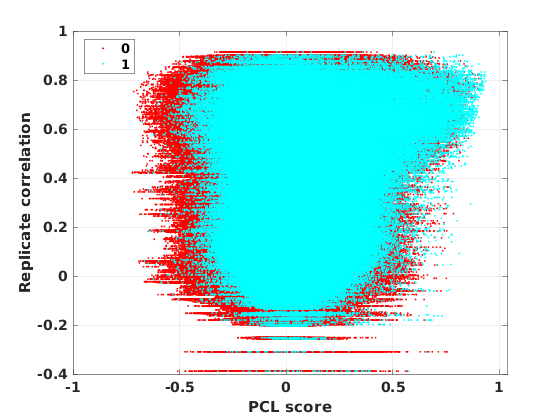

In [55]:
figure
    gscatter(ss_tbl.pcl_score,ss_tbl.rcorr,ss_tbl.pcl_and_moa_agree)
    xlabel('PCL score')
    ylabel('Replicate correlation')


auc =

    0.5531


optrocpt =

    0.0000    0.0015



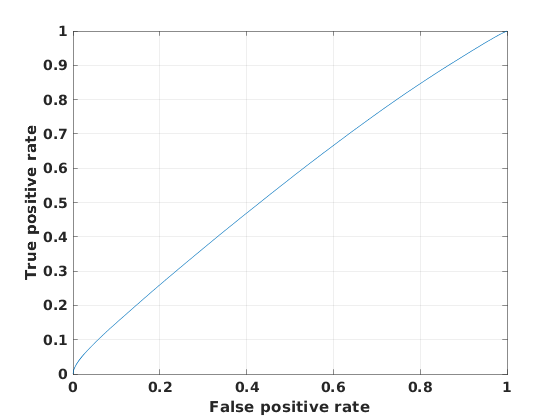

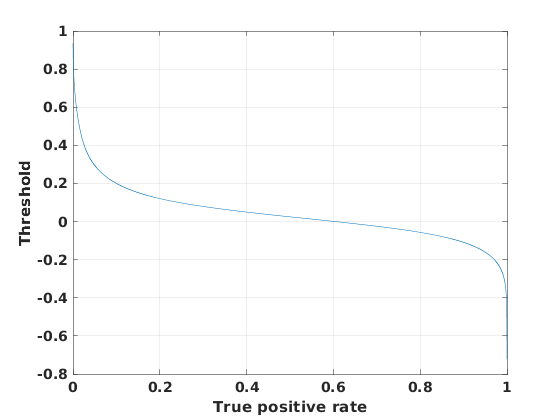

In [56]:
[x,y,t,auc,optrocpt] = perfcurve(ss_tbl.pcl_and_moa_agree,ss_tbl.pcl_score,1);
auc
optrocpt

figure
    plot(x,y)
    xlabel('False positive rate')
    ylabel('True positive rate')
figure
    plot(y,t)
    xlabel('True positive rate')
    ylabel('Threshold')

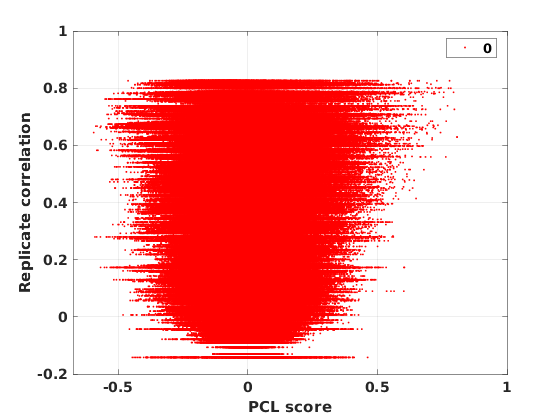

In [57]:
figure
    gscatter(ss_tbl_test_cmpd.pcl_score,ss_tbl_test_cmpd.rcorr,ss_tbl_test_cmpd.pcl_and_moa_agree)
    xlabel('PCL score')
    ylabel('Replicate correlation')
    %xlim([-1, 1])
    %ylim([-1, 1])

## Select PCLs with rank 1

In [58]:
idx = ~isnan(ss_tbl.pcl_score);
sum(idx)
ss_tbl_sele = ss_tbl(idx,:);


ans =

    18363796



## For each compound select profile that is most similar to some PCL

In [59]:
duplicates(ss_tbl_sele.broad_id)


ans =

  505x1 cell array

    {'BRD-A05468928-003-01-4' }
    {'BRD-A07244995-001-01-9' }
    {'BRD-A24228527'          }
    {'BRD-A24228527-001-33-1' }
    {'BRD-A24397426-001-12-0' }
    {'BRD-A41450521-075-11-6' }
    {'BRD-A47790386-001-04-4' }
    {'BRD-A69777949-001-26-7' }
    {'BRD-A74980173-999-99-9' }
    {'BRD-A74980173-001-13-5' }
    {'BRD-A92341659-001-05-7' }
    {'BRD-A93964801-001-17-7' }
    {'BRD-K04804440-001-16-0' }
    {'BRD-K04804440-001-13-7' }
    {'BRD-K08525451-001-03-1' }
    {'BRD-K08525451-003-06-0' }
    {'BRD-K08999871-001-15-4' }
    {'BRD-K09471561'          }
    {'BRD-K09471561-001-21-6' }
    {'BRD-K09471561-001-22-4' }
    {'BRD-K10362825-001-05-9' }
    {'BRD-K10362825-001-04-2' }
    {'BRD-K11196887-001-24-6' }
    {'BRD-K14704277-001-25-9' }
    {'BRD-K28247815-001-01-3' }
    {'BRD-K32368635-001-01-9' }
    {'BRD-K37798499-001-28-0' }
    {'BRD-K37798499-001-16-5' }
    {'BRD-K45916615-001-03-0' }
    {'BRD-K47869605-001-33-8' }
    {'BRD-K4

In [60]:
numel(unique(ss_tbl_sele.pert_id))
numel(unique(ss_tbl_sele.broad_id))
numel(unique(ss_tbl_sele.proj_broad_id))
numel(unique(ss_tbl_sele.cid))


ans =

   437


ans =

   505


ans =

   967


ans =

        9427



In [61]:
ss_tbl_reset = ss_tbl_sele;

## Iterate for each PCL

In [62]:
pcl_list = unique(ss_tbl_sele.rid);
length(pcl_list)


ans =

        1948



In [63]:
moa_list = unique(ss_tbl_sele.pcl_desc);
length(moa_list)


ans =

    71



#### Filter out MOA in-separable PCLs prior to iterating

In [64]:
% filter out MOA in-separable PCLs prior to iterating

% Find the row with the maximum pcl_score for each rid
maxPclScore = groupsummary(ss_tbl_sele, 'rid', @max, 'pcl_score');

size(maxPclScore)

head(maxPclScore)


ans =

        1948           3


ans =

  8x3 table

               rid               GroupCount    fun1_pcl_score
    _________________________    __________    ______________

    {'30S ribosome:group1'  }       9427          0.23901    
    {'30S ribosome:group100'}       9427          0.81249    
    {'30S ribosome:group104'}       9427          0.81079    
    {'30S ribosome:group11' }       9427          0.52896    
    {'30S ribosome:group111'}       9427          0.66303    
    {'30S ribosome:group115'}       9427          0.39989    
    {'30S ribosome:group119'}       9427          0.25734    
    {'30S ribosome:group132'}       9427          0.42159    



In [65]:
size(ss_tbl_sele)

ss_tbl_sele = innerjoin(ss_tbl_sele, maxPclScore, 'Keys', 'rid');

size(ss_tbl_sele)

headt(ss_tbl_sele)


ans =

    18363796          48


ans =

    18363796          50


ans =

  50x3 table

    idx               field                                               value                                 
    ___    ___________________________    ______________________________________________________________________

     1     {'cid'                    }    "kabx2:BRD-A05468928-003-01-4:0.097500uM"                             
     2     {'broad_id'               }    "BRD-A05468928-003-01-4"                                              
     3     {'canonical_smiles'       }    "-666"                                                                
     4     {'cid_org'                }    "kabx2:BRD-A05468928-003-01-4:0.097500uM"                             
     5     {'dose_series_id'         }    "kabx_dose_series"                                                    
     6     {'n_replicates'           }    "2"                                                                   
     

In [66]:
% Get the rows with the maximum pcl_score
maxRows = ss_tbl_sele(ss_tbl_sele.pcl_score >= ss_tbl_sele.fun1_pcl_score,:);

size(maxRows)

headt(maxRows)


ans =

        2132          50


ans =

  50x3 table

    idx               field                                               value                                 
    ___    ___________________________    ______________________________________________________________________

     1     {'cid'                    }    "kabx2:BRD-K40939496-001-01-5:0.781250uM"                             
     2     {'broad_id'               }    "BRD-K40939496-001-01-5"                                              
     3     {'canonical_smiles'       }    "-666"                                                                
     4     {'cid_org'                }    "kabx2:BRD-K40939496-001-01-5:0.781250uM"                             
     5     {'dose_series_id'         }    "kabx_dose_series"                                                    
     6     {'n_replicates'           }    "2"                                                                   
     7     {'pert_dose'              } 

In [67]:
% Find the rows where pcl_and_moa_agree = 1
pclListRows = maxRows(maxRows.pcl_and_moa_agree == 1,:);

% Get the rids of these rows
pcl_list = unique(pclListRows.rid);

length(pcl_list)


ans =

        1127



In [68]:
moa_list = unique(pclListRows.pcl_desc);
length(moa_list)


ans =

    68



#### Subset ss_tbl_sele to only include MOA separable PCLs

In [69]:
size(ss_tbl_sele)

ss_tbl_sele = ss_tbl_sele(ismember(ss_tbl_sele.rid, pcl_list),:);

size(ss_tbl_sele)


ans =

    18363796          50


ans =

    10624229          50



In [70]:
numel(unique(ss_tbl_sele.pert_id))
numel(unique(ss_tbl_sele.broad_id))
numel(unique(ss_tbl_sele.proj_broad_id))
numel(unique(ss_tbl_sele.cid))


ans =

   437


ans =

   505


ans =

   967


ans =

        9427



#### Subset test set to only include MOA separable PCLs

In [71]:
size(ss_tbl_test_cmpd)

ss_tbl_test_cmpd = ss_tbl_test_cmpd(ismember(ss_tbl_test_cmpd.rid, pcl_list),:);

size(ss_tbl_test_cmpd)


ans =

     2711616          48


ans =

     1568784          48



In [72]:
numel(unique(ss_tbl_test_cmpd.pert_id))
numel(unique(ss_tbl_test_cmpd.broad_id))
numel(unique(ss_tbl_test_cmpd.proj_broad_id))
numel(unique(ss_tbl_test_cmpd.cid))


ans =

   174


ans =

   174


ans =

   174


ans =

        1392



#### Re-save ss_tbl_reset accordingly and verify pcl_list has shortened

In [73]:
ss_tbl_reset = ss_tbl_sele;

In [74]:
pcl_list = unique(ss_tbl_sele.rid);
length(pcl_list)


ans =

        1127



In [75]:
moa_list = unique(ss_tbl_sele.pcl_desc);
length(moa_list)


ans =

    68



In [76]:
pcls = parse_gmt(pcls_moa_path);
pcls_tbl = struct2table(pcls);
headt(pcls_tbl)
size(pcls_tbl)


ans =

  4x3 table

    idx      field               value         
    ___    _________    _______________________

     1     {'head' }    {'30S ribosome:group1'}
     2     {'desc' }    {'30S ribosome'       }
     3     {'len'  }    {[                  4]}
     4     {'entry'}    {4x1 cell             }


ans =

        1948           4



In [77]:
tic

out_tbl = {};
opt_tbl = {};
out_tbl_test_cmpd = {};

for i = 1:numel(pcl_list)
%for i = 3:3

    %ss_tbl_sele = ss_tbl_reset;

    choose_pcl = pcl_list(i)
    
    jj = find(ismember(pcls_tbl.head, choose_pcl))

    pcls(jj).entry
    
    %this_pcl_size = sum(ismember(c.cid,pcls(jj).entry))
    this_pcl_size = pcls(jj).len

    idx = strcmp(ss_tbl_reset.rid, choose_pcl);
    sum(idx)

    ss_tbl_sele = ss_tbl_reset(idx,:);
    size(ss_tbl_sele)

    choose_pcl_desc = ss_tbl_sele.pcl_desc(1);

    %ss_tbl_sele = sortrows(ss_tbl_sele,{'broad_id','pcl_score'},{'ascend','ascend'});
    ss_tbl_sele = sortrows(ss_tbl_sele,{'pcl_score'},{'descend'});
    [unique_brds, idx] = unique(ss_tbl_sele.pert_id, 'stable');
    numel(idx)

    min_rcorr = min(ss_tbl_sele.rcorr);

    %highest_cmpd_min_pcl_score = min(ss_tbl_sele.pcl_score(idx))

    highest_cmpd_min_pcl_score = -Inf;

    %%% DO take all treatment scores
    
    all_trt_score_tbl = ss_tbl_sele(:, {'cid','pert_id','broad_id','proj_broad_id','target_description','pcl_score','rcorr','pcl_and_moa_agree'});
    
    %all_trt_score_tbl.cmpd_index = repmat(nan,[size(all_trt_score_tbl, 1) 1]);

    %all_trt_scores = unique(table2array(all_trt_score_tbl(all_trt_score_tbl.pcl_score >= highest_cmpd_min_pcl_score, 'pcl_score')));
    all_trt_scores = all_trt_score_tbl.pcl_score(all_trt_score_tbl.pcl_score >= highest_cmpd_min_pcl_score);
    all_trt_labels = all_trt_score_tbl.pcl_and_moa_agree(all_trt_score_tbl.pcl_score >= highest_cmpd_min_pcl_score);

    ss_tbl_sele = ss_tbl_sele(idx,:);
    
    %all_trt_scores = ss_tbl_sele.pcl_score;
    %all_trt_labels = ss_tbl_sele.pcl_and_moa_agree;
    
    %all_trt_score_tbl = ss_tbl_sele(:, {'cid','broad_id','target_description','pcl_score','rcorr','pcl_and_moa_agree'});
    
    %all_trt_score_tbl.cmpd_index = repmat(nan,[size(all_trt_score_tbl, 1) 1]);

    num_correct = sum(ss_tbl_sele.pcl_and_moa_agree == 1)

    pcl_n = size(ss_tbl_sele, 1);

    tmp_opt_tbl = {};

    tmp_opt_tbl.pcl_rid = choose_pcl;
    tmp_opt_tbl.pcl_desc = choose_pcl_desc;
    tmp_opt_tbl.pcl_n = pcl_n;
    tmp_opt_tbl.pcl_n_correct = num_correct;
    tmp_opt_tbl.pcl_n_trt = length(all_trt_scores);
    tmp_opt_tbl.pcl_n_correct_trt = sum(all_trt_labels);

    if num_correct > 0

        train_cmpds = ss_tbl_sele.pert_id;
        
        train_pert_ids = ss_tbl_sele.pert_id;

        full_scores = ss_tbl_sele.pcl_score;

        assert(issorted(all_trt_scores, 'descend'))

        assert(issorted(full_scores, 'descend'))

        %full_train_scores = max(full_scores)-full_scores;
        full_train_scores = full_scores;

        full_labels = ss_tbl_sele.pcl_and_moa_agree;

        [fpr,tpr,t,auc,optrocpt] = perfcurve(full_labels,full_train_scores,1,'NegClass',0,'UseNearest','off','XVals','all','Cost',[0 1; 1 0]);
        auc
        optrocpt
        [ppv,tpr,t] = perfcurve(full_labels,full_train_scores,1,'XCrit','ppv','NegClass',0,'UseNearest','off','XVals','all','Cost',[0 1; 1 0]);

        ppv_full = interp1(unique(full_scores, 'stable'), ppv(2:end), all_trt_scores,'next');
        
        ppv_full = fillmissing(ppv_full, 'nearest');

        isOptimalPoint = ismember([fpr, tpr], optrocpt, 'rows');

        % Use find to return the indices of the rows that match the 1-by-2 array
        optimalPoint = find(isOptimalPoint(2:end)) + 1;

        tmp_opt_tbl.pcl_auc = auc;

        if length(optimalPoint)>0

            optimalPPV = ppv(optimalPoint);

            full_model_opt_score_thres = all_trt_scores(max(find(single(ppv_full) >= single(optimalPPV))))
            optimalPPV

            full_model_next_score_thres = all_trt_scores(max(find(single(ppv_full) >= single(optimalPPV)))+1)
            full_model_next_score_ppv = ppv_full(max(find(single(ppv_full) >= single(optimalPPV)))+1)
            
            full_model_next_score_idx = max(find(single(ppv_full) >= single(optimalPPV)))+1;


            tmp_opt_tbl.pcl_score_threshold = full_model_opt_score_thres;
            tmp_opt_tbl.ppv = ppv(optimalPoint);
            tmp_opt_tbl.tpr = tpr(optimalPoint);
            tmp_opt_tbl.fpr = fpr(optimalPoint);
        else

            optimalPPV = nan;

            full_model_opt_score_thres = nan
            optimalPPV

            full_model_next_score_thres = nan
            full_model_next_score_ppv = nan
            
            full_model_next_score_idx = 1;

            tmp_opt_tbl.pcl_score_threshold = nan;
            tmp_opt_tbl.ppv = nan;
            tmp_opt_tbl.tpr = nan;
            tmp_opt_tbl.fpr = nan;
        end

    else
        ppv_full = repmat(nan,[size(all_trt_score_tbl, 1) 1]);
        
        full_model_opt_score_thres = nan;
        full_model_next_score_thres = all_trt_score_tbl.pcl_score(1);
        full_model_next_score_ppv = 0;
        
        full_model_next_score_moa = all_trt_score_tbl.target_description(1);

        tmp_opt_tbl.pcl_auc = nan;

        tmp_opt_tbl.pcl_score_threshold = nan;
        tmp_opt_tbl.ppv = nan;
        tmp_opt_tbl.tpr = nan;
        tmp_opt_tbl.fpr = nan;

    end
    
    all_trt_score_tbl = all_trt_score_tbl(all_trt_score_tbl.pcl_score >= highest_cmpd_min_pcl_score, :);

    full_model_next_score_moa = all_trt_score_tbl.target_description(full_model_next_score_idx);

    tmp_opt_tbl.next_score_moa = full_model_next_score_moa;

    %all_trt_score_tbl.full_model_opt_score_thres = repmat(full_model_opt_score_thres, [size(all_trt_score_tbl, 1) 1]);
    %all_trt_score_tbl.full_model_next_score_thres = repmat(full_model_next_score_thres, [size(all_trt_score_tbl, 1) 1]);
    %all_trt_score_tbl.full_model_next_score_ppv = repmat(full_model_next_score_ppv, [size(all_trt_score_tbl, 1) 1]);
    %all_trt_score_tbl.full_model_next_score_moa = repmat(full_model_next_score_moa, [size(all_trt_score_tbl, 1) 1]);
    
    all_trt_score_tbl.ppv = ppv_full;
    
    all_trt_score_tbl.rid = repmat(choose_pcl,[size(all_trt_score_tbl, 1) 1]);
    all_trt_score_tbl.pcl_desc = repmat(choose_pcl_desc,[size(all_trt_score_tbl, 1) 1]);


    out_tbl = [out_tbl; all_trt_score_tbl];

    tmp_opt_tbl = struct2table(tmp_opt_tbl);
    
    tmp_opt_tbl.full_model_opt_score_thres = full_model_opt_score_thres;
    tmp_opt_tbl.full_model_next_score_thres = full_model_next_score_thres;
    tmp_opt_tbl.full_model_next_score_ppv = full_model_next_score_ppv;

    opt_tbl = [opt_tbl; tmp_opt_tbl];
    
    
    % test section % 
    
    test_idx = strcmp(ss_tbl_test_cmpd.rid, choose_pcl);
    sum(test_idx)

    ss_tbl_sele_test_cmpd = ss_tbl_test_cmpd(test_idx,:);
    size(ss_tbl_sele_test_cmpd)

    ss_tbl_sele_test_cmpd = sortrows(ss_tbl_sele_test_cmpd,{'pcl_score'},{'descend'});

    %%% DO take all treatment scores
    
    all_trt_score_tbl_test_cmpd = ss_tbl_sele_test_cmpd(:, {'cid','pert_id','broad_id','proj_broad_id','target_description','pcl_score','rcorr','pcl_and_moa_agree'});
    
    %all_trt_score_tbl_test_cmpd.cmpd_index = repmat(nan,[size(all_trt_score_tbl_test_cmpd, 1) 1]);

    all_trt_scores_test_cmpd = all_trt_score_tbl_test_cmpd.pcl_score;
    all_trt_labels_test_cmpd = all_trt_score_tbl_test_cmpd.pcl_and_moa_agree;
    
    [score_thresholds, idx_unique] = unique(all_trt_scores, 'stable');
    
    test_ppv = interp1(score_thresholds, ppv_full(idx_unique), all_trt_scores_test_cmpd, 'linear');
    
    test_ppv = fillmissing(test_ppv, 'nearest');

    assert(sum(isnan(test_ppv)) == 0)
    
    all_trt_score_tbl_test_cmpd.test_ppv = test_ppv;
    
    all_trt_score_tbl_test_cmpd.rid = repmat(choose_pcl,[size(all_trt_score_tbl_test_cmpd, 1) 1]);
    all_trt_score_tbl_test_cmpd.pcl_desc = repmat(choose_pcl_desc,[size(all_trt_score_tbl_test_cmpd, 1) 1]);


    out_tbl_test_cmpd = [out_tbl_test_cmpd; all_trt_score_tbl_test_cmpd];

    
    % End test section %

end

wtable(out_tbl,fullfile(wkdir,'by_pcl_score_thresholds_based_on_median_corr_ppv_per_cmpd_full_test_moa_separable_only.txt'));

wtable(opt_tbl,fullfile(wkdir,'by_pcl_optimal_score_thresholds_based_on_median_corr_ppv_per_cmpd_full_test_moa_separable_only.txt'));

wtable(out_tbl_test_cmpd,fullfile(wkdir,'by_pcl_full_test_results_moa_separable_only.txt'));

toc


choose_pcl =

  1x1 cell array

    {'30S ribosome:group1'}


jj =

     1


ans =

  4x1 cell array

    {'kabx2:BRD-K01825150-001-16-9:50.000000uM'}
    {'kabx2:BRD-A62336573-001-05-6:0.781250uM' }
    {'kabx2:BRD-K40939496-001-01-5:3.125000uM' }
    {'kabx2:BRD-K40939496-001-01-5:0.781250uM' }


this_pcl_size =

     4


ans =

        9427


ans =

        9427          50


ans =

   437


num_correct =

    25


auc =

    0.4376


optrocpt =

         0    0.0800


full_model_opt_score_thres =

  single

    0.2180


optimalPPV =

     1


full_model_next_score_thres =

  single

    0.2046


full_model_next_score_ppv =

  single

    0.6667


ans =

        1392


ans =

        1392          48


choose_pcl =

  1x1 cell array

    {'30S ribosome:group100'}


jj =

    41


ans =

  27x1 cell array

    {'kabx2:BRD-A34145622-003-26-9:50.000000uM'}
    {'kabx2:BRD-A15637061-003-01-9:50.000000uM'}
    {'kabx2:BRD-A69651145-003-12-2:50.000000uM'}
    {'kabx2:BRD-A69651145-003-12

In [78]:
i
%ii


i =

        1127



In [79]:
all_trt_score_tbl_test_cmpd


all_trt_score_tbl_test_cmpd =

  1392x11 table

                          cid                                   pert_id                      broad_id                                  proj_broad_id                          target_description     pcl_score        rcorr       pcl_and_moa_agree    test_ppv                rid                     pcl_desc     
    ________________________________________________    ________________________    __________________________    ________________________________________________________    __________________    ___________    ___________    _________________    _________    __________________________    __________________

    {'tbda1:ST-876385:100.000000uM'                }    {'ST-876385'           }    {'ST-876385'             }    "screen4wk_screen5wk_tbda1_kabx2:ST-876385"                     {0x0 char}            0.25021        0.53757            0             0.029134    {'tRNA synthesis:group67'}    {'tRNA synthesis'}
    {'tbda1:JM108692-13

In [80]:
out_tbl_test_cmpd(1:30, :)


ans =

  30x11 table

                       cid                              pert_id               broad_id                            proj_broad_id                      target_description    pcl_score      rcorr      pcl_and_moa_agree    test_ppv              rid                  pcl_desc    
    __________________________________________    ___________________    ___________________    _________________________________________________    __________________    _________    _________    _________________    ________    _______________________    ________________

    {'tbda1:ST-1032424:0.097656uM'           }    {'ST-1032424'     }    {'ST-1032424'     }    "screen4wk_screen5wk_tbda1_kabx2:ST-1032424"             {0x0 char}         0.17895       0.14276            0             0.28725    {'30S ribosome:group1'}    {'30S ribosome'}
    {'tbda1:ST-2511852:3.125000uM'           }    {'ST-2511852'     }    {'ST-2511852'     }    "screen4wk_screen5wk_tbda1_kabx2:ST-2511852"             {

In [81]:
full_model_next_score_moa


full_model_next_score_moa =

  1x1 cell array

    {'Pks13'}



In [82]:
opt_tbl(1:30, :)


ans =

  30x15 table

             pcl_rid                 pcl_desc        pcl_n    pcl_n_correct    pcl_n_trt    pcl_n_correct_trt    pcl_auc    pcl_score_threshold      ppv        tpr         fpr                  next_score_moa                full_model_opt_score_thres    full_model_next_score_thres    full_model_next_score_ppv
    _________________________    ________________    _____    _____________    _________    _________________    _______    ___________________    _______    _______    _________    _____________________________________    __________________________    ___________________________    _________________________

    {'30S ribosome:group1'  }    {'30S ribosome'}     437          25            9427              477           0.43757          0.21802                1       0.08            0    {'Alr|DdlA'                         }             0.21802                         0.2046                       0.66667         
    {'30S ribosome:group100'}    {'30S ribosom

In [83]:
opt_tbl(1, :)


ans =

  1x15 table

            pcl_rid                pcl_desc        pcl_n    pcl_n_correct    pcl_n_trt    pcl_n_correct_trt    pcl_auc    pcl_score_threshold    ppv    tpr     fpr    next_score_moa    full_model_opt_score_thres    full_model_next_score_thres    full_model_next_score_ppv
    _______________________    ________________    _____    _____________    _________    _________________    _______    ___________________    ___    ____    ___    ______________    __________________________    ___________________________    _________________________

    {'30S ribosome:group1'}    {'30S ribosome'}     437          25            9427              477           0.43757          0.21802           1     0.08     0      {'Alr|DdlA'}              0.21802                        0.2046                        0.66667         



In [84]:
out_tbl(1:30, 2:end)


ans =

  30x10 table

         pert_id                  broad_id                                  proj_broad_id                                                target_description                           pcl_score      rcorr      pcl_and_moa_agree      ppv                 rid                  pcl_desc    
    _________________    __________________________    ________________________________________________________    _______________________________________________________________    _________    _________    _________________    ________    _______________________    ________________

    {'BRD-K40939496'}    {'BRD-K40939496-001-01-5'}    "screen4wk_screen5wk_tbda1_kabx2:BRD-K40939496-001-01-5"    {'30S ribosome'                                               }     0.23901       0.11359            1                   1    {'30S ribosome:group1'}    {'30S ribosome'}
    {'BRD-K01825150'}    {'BRD-K01825150-001-16-9'}    "screen4wk_screen5wk_tbda1_kabx2:BRD-K01825150-001-16-9"    {'30S 

In [85]:
out_tbl(height(out_tbl)-30:end, 4:end)


ans =

  31x8 table

                         proj_broad_id                                                target_description                           pcl_score      rcorr      pcl_and_moa_agree      ppv                 rid                     pcl_desc     
    ________________________________________________________    _______________________________________________________________    _________    _________    _________________    _______    __________________________    __________________

    "screen6:BRD-K31807080-001-01-7"                            {'Pks13'                                                      }    -0.15539      0.061457            0            0.01373    {'tRNA synthesis:group67'}    {'tRNA synthesis'}
    "screen6:BRD-K31807080-001-01-7"                            {'Pks13'                                                      }    -0.15568      0.017382            0            0.01373    {'tRNA synthesis:group67'}    {'tRNA synthesis'}
    "screen6:BRD-K1482154

%ss_tbl_sele(1:5, {'broad_id', 'pcl_score', 'pcl_and_moa_agree'})

all_trt_score_tbl(1:30, 4:end)